In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
is_cuda_available = torch.cuda.is_available()

### Load STL-10

In [4]:
classes = ()

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train data
batch_size = 32
trainset = torchvision.datasets.STL10(root='./data',
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [6]:
total = len(trainset)
ind = list(range(total))
n_train = int(np.floor((0.9) * total))
train_ind, validation_ind = ind[:n_train], ind[n_train:]
train_subsampler = torch.utils.data.sampler.SubsetRandomSampler(train_ind)
validation_subsampler = torch.utils.data.sampler.SubsetRandomSampler(validation_ind)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                           sampler=train_subsampler, num_workers=0)
validation_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                sampler=validation_subsampler, num_workers=0)

print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(validation_loader)))

Number of training batches: 141
Number of validation batches: 16


# Show images

In [7]:
def show_images(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

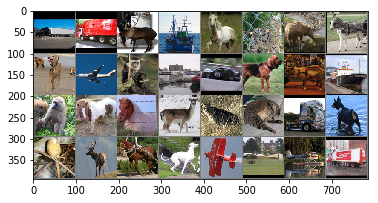

In [8]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
show_images(torchvision.utils.make_grid(images))
# print labels

# Shuffle Images

In [9]:
def permute_pieces(images):
    """
    Shuffle pieces pieces.
    """
    size = images.shape[0]
    perm = torch.randperm(size)
    
    perm_mat = torch.zeros(size, size)
    perm_mat[torch.arange(size).long(), perm] = 1
    return images[perm].contiguous(), perm_mat

# Cut Images

In [10]:
def cut_torch_imgs(imgs, shape = (4,4)):
    # imgs is a batch of images -- expected n*c*h*w
    # shape is the shape of each piece
    # returns n*pieces*c*h*w
    assert len(imgs.shape) == 4,"Provide batches of inputs"
    assert not imgs.shape[2] % shape[0], "undivisible height for piece size"
    assert not imgs.shape[3] % shape[1], "undivisible width for piece size"
    
    a = imgs.transpose(1, 2).transpose(2,3).contiguous()
    c = a[0].shape[-1]
    x,y = a[0].shape[0]//shape[0], a[0].shape[1]//shape[1]
    b = a.view(-1,x,shape[0],y,shape[1],c)
    b = b.transpose(2,3).contiguous()
    b = b.view(-1,x*y,shape[0],shape[1],c)
    #transpose to torch accepted standard
    b = b.transpose(3,4).transpose(2,3).contiguous()
    res = []
    for i in range(b.shape[0]):
        temp, perm = permute_pieces(b[i])
        b[i] = temp
        res.append(perm)
    res = torch.stack(res)
    return b, res.reshape(-1, res.shape[1]*res.shape[2])

# Models

In [11]:
vgg16 = models.vgg16(pretrained=True)

In [12]:
# model = nn.Sequential(*list(vgg16.features.children())[:24])
vgg_part = nn.Sequential(vgg16.features)

# LSTM Test 1

In [ ]:
torch.randn(1, 1, 3)

In [ ]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    print(hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension

In [ ]:
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

In [ ]:
# Update the progress bar.
            print("Epoch {0:03d}: loss={1:.4f}, val_loss={2:.4f}, acc={3:.2%}, val_acc={4:.2%}".format(
                epoch + 1, loss_history[-1], val_loss_history[-1], acc_history[-1], val_acc_history[-1]))
    print('Training completed')
    history = {
        'loss': loss_history,
        'val_loss': val_loss_history,
        'acc': acc_history,
        'val_acc': val_acc_history
    }
    # Save the model when requested.
    if save_file_name is not None:
        torch.save({
            'history': history,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, save_file_name)
    return history

# Custom Metrics

In [13]:
def preflow_accuracy(p_pred, p_true, pieces = 9, average=True):
    """
    We require that the location of all four pieces are correctly predicted.
    Note: this function is compatible with GPU tensors.
    """
    # Remember to cast to float.
    p_pred = preflow_bipartite(p_pred, pieces)
#     print(p_pred.shape, p_true.shape)
#     print(p_pred)
    n = torch.sum((torch.sum(p_pred == p_true, 1) == 9).float())
    if average:
        return n / p_pred.shape[0]
    else:
        return n

In [14]:
from scipy.sparse import csr_matrix
import networkx as nx

def preflow_bipartite(x, pieces = 9):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """    
    x = x.clone()
    x = x.view(-1, x.shape[1]//pieces, pieces).detach().numpy()
    res = []
    for val in x:
        G = nx.bipartite.from_biadjacency_matrix(csr_matrix(val))
        matches = nx.algorithms.matching.max_weight_matching(G)
        pieces = val.shape[0]
        res_mat = np.zeros((pieces, pieces))
        for i, j in matches:
            if i >= pieces:
                i, j = j, i
            res_mat[i % pieces, j % pieces] = 1
        res.append(res_mat.reshape(pieces*pieces))

    return torch.FloatTensor(res)

# Sai 

In [15]:
for param in vgg_part.parameters():
    param.requires_grad = False
vgg_part = torch.nn.DataParallel(vgg_part)
vgg_part = vgg_part.cuda if is_cuda_available else vgg_part

In [16]:
tem = [[1,1],[2,2],[3,3],[4,4]]
tem = np.array(tem)
print(tem, tem.shape)

res = [[[1,2],[3,4]], [[1,2],[3,4]]]
np.array(res)

[[1 1]
 [2 2]
 [3 3]
 [4 4]] (4, 2)


array([[[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]]])

In [23]:
class JigsawNet(nn.Module):
    """
    A neural network that solves 2x2 jigsaw puzzles.
    """
    def __init__(self, sinkhorn_iter=0):
        global vgg_part
        super(JigsawNet, self).__init__()
        self.vgg = vgg_part
        self.fc1 = nn.Linear(9*512, 256)
        self.fc1_bn = nn.BatchNorm1d(256)
        # 4 x 4 assigment matrix
        self.fc2 = nn.Linear(256, 81)
    
    def forward(self, x):
        # Split the input into four pieces and pass them into the
        # same convolutional neural network.
        vgg_out = []
        for i in range(x.shape[1]):
            vgg_out.append(self.vgg(x[:,i]).squeeze())
        # Cat
        x = torch.cat(vgg_out, dim=1)
        # Dense layer
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

In [24]:
net = JigsawNet()
is_cuda_available = torch.cuda.is_available();
if is_cuda_available:
    net = net.cuda()

In [25]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [26]:
save_file_name = "PleaseWorkModel.pkl"

In [27]:
loss_history = []
val_loss_history = []
acc_history = []
val_acc_history = []
nb_epochs = 1
for epoch in range(nb_epochs):
    running_loss = 0.0
    n_correct_pred = 0
    n_samples = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
#         print(data)
        inputs, labels = cut_torch_imgs(data[0], (32,32))
        n_samples += inputs.size()[0]
        if is_cuda_available:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size()[0]
        n_correct_pred += preflow_accuracy(outputs, labels)
        
        loss_history.append(running_loss / n_samples)
        acc_history.append(n_correct_pred / n_samples)
        if i % 1 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print('Finished Training')
history = {
        'loss': loss_history,
        'acc': acc_history,
    }
# Save the model when requested.
if save_file_name is not None:
    torch.save({
        'history': history,
        'model': net.state_dict(),
        'optimizer': optimizer.state_dict()
    }, save_file_name)

[1,     1] loss: 22.684
[1,     2] loss: 22.097
[1,     3] loss: 21.484


Process Process-3:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeou

KeyboardInterrupt: 

# Stuff

# jayanth